# Alternative Approach: Sentiment Analysis - Bert Base + Neural Network (Tensorflow) - Python(tf) kernel

### Attempts without bias handling, undersampling and oversampling, with variation of neurons in hidden layer. Since not much difference is observed in metrics, result/metrics of each approach with some additional code is added as markdown

## First Approach without handling bias (Overkill with 1024 neurons in hidden layer)

In [ ]:
pip install sklearn

In [1]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn


import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import classification_report

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import string
from nltk.corpus import stopwords
#import openai

from transformers import pipeline

C:\Users\calmeida\Anaconda3\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Read the file
data = pd.read_csv('WomensClothingECommerceReviews.csv')

In [3]:
# Drop the rows with nan's in the review text-I chose to keep the nan's in the title because the review text is the column we will use
data.dropna(subset='Review Text',inplace=True)

In [4]:
# The Title text wherever available is added to the review text to utilise all available feedback
cols = ['Title', 'Review Text']
data['Concat']= data[cols].apply(lambda x: ' '.join(i for i in x if pd.notna(i)), axis=1)

In [5]:
data.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Concat
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,Absolutely wonderful - silky and sexy and comf...
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,Love this dress! it's sooo pretty. i happene...
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,Some major design flaws I had such high hopes ...
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,"My favorite buy! I love, love, love this jumps..."
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,Flattering shirt This shirt is very flattering...


In [6]:
# Count the number of reviews for each rating
rating_counts = data['Rating'].value_counts().sort_index()

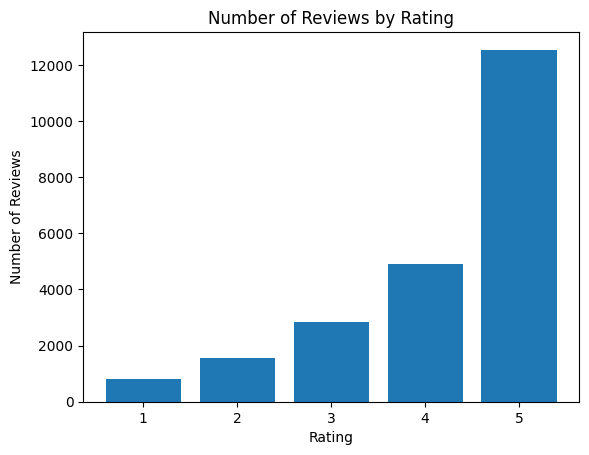

In [7]:
# Draw a bar chart
plt.bar(rating_counts.index, rating_counts.values)
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.title('Number of Reviews by Rating')
plt.show()

In [8]:
# Get numerical count only
count_values = rating_counts.values

# Print the count
for count in count_values:
    print(count)

821
1549
2823
4908
12540


#Dataset is highly skewed toward 5 star reviews. Ths bias to be avoided during training the model #Note that Rating of 3 corresponds to only 2823 reviews. However, a fresh set of reviews needn't have the same distribution

#Current approach in the training block below does not compensate for the bias toward 5-star reviews

In [15]:
nan_counts = data.isna().sum()
print(nan_counts)


Unnamed: 0                    0
Clothing ID                   0
Age                           0
Title                      2966
Review Text                   0
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Division Name                13
Department Name              13
Class Name                   13
Concat                        0
dtype: int64


In [16]:
new_data = data[['Clothing ID', 'Rating', 'Concat']].copy()

In [17]:
nan_counts1 = new_data.isna().sum()
print(nan_counts1)

Clothing ID    0
Rating         0
Concat         0
dtype: int64


In [18]:
len(new_data)

22641

In [6]:
pip install transformers


Note: you may need to restart the kernel to use updated packages.


In [19]:
print(len(new_data))               # Length of the DataFrame
print(len(new_data['Concat']))     # Length of the 'Concat' column


22641
22641


In [18]:
from transformers import BertTokenizer


In [ ]:
pip install tensorflow


In [36]:
import tensorflow as tf
import numpy as np
from transformers import BertTokenizer, TFAutoModel

# Load and preprocessing a dataframe with features of interest
new_data = data[['Clothing ID', 'Rating', 'Concat']].copy()

# We set the sequence length and no. of samples
seq_len = 512
num_samples = len(new_data)

# Creating zero arrays for input data - Xids array stores input IDs i.e. numerical representations of the tokenized text
#Xmask array stores the attention masks, which indicate which tokens should be utilised and which tokens should be ignored
# BERT tokenizer adds tokens or truncates/pads the tokenized sequence to reach seq_len which is chosen as 512 since BERT pretraining 
#was actually performed with sequences of up to 512 tokens.

Xids = np.zeros((num_samples, seq_len))
Xmask = np.zeros((num_samples, seq_len))

# Initializing the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

# Process each phrase in the new_data DataFrame

for i, phrase in enumerate(new_data['Concat']):
    tokens = tokenizer.encode_plus(phrase, max_length=seq_len, truncation=True,
                                   padding='max_length', add_special_tokens=True,
                                   return_tensors='tf')
    Xids[i, :] = tokens['input_ids']
    Xmask[i, :] = tokens['attention_mask']
    
# Creating one-hot encoded labels
arr = new_data['Rating'].values
num_classes = len(np.unique(arr))
labels = np.zeros((len(new_data), num_classes))
labels[np.arange(len(new_data)), arr - 1] = 1

#TensorFlow dataset from the input data and labels
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))


In [37]:
# function defined to format/restructure elements of the dataset, taking input_ids, masks, and labels as arguments and returning 
#a dictionary containing (input_ids and attention_mask) along with the labels. 
def map_func(input_ids, masks, labels):
    return {'input_ids': input_ids, 'attention_mask': masks}, labels

dataset = dataset.map(map_func)

#batch_size can be varied to optimise and shuffling a buffer of elements for each batch , 
#allows the sample order is randomised to prevent bias.buffer size limited by RAM avaialble etc.
batch_size = 16
dataset = dataset.shuffle(10000).batch(batch_size, drop_remainder=True)

#Split to train and validate
split = 0.9
size = int((Xids.shape[0] / batch_size) * split)

train_ds = dataset.take(size)
val_ds = dataset.skip(size)

# model architecture
bert = TFAutoModel.from_pretrained('bert-base-cased')

input_ids = tf.keras.layers.Input(shape=(512,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(512,), name='attention_mask', dtype='int32')

embeddings = bert.bert(input_ids, attention_mask=mask)[1]
x = tf.keras.layers.Dense(1024, activation='relu')(embeddings)
y = tf.keras.layers.Dense(5, activation='softmax', name='outputs')(x)

model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-6)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])





Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [64]:
# Initial Training
try:
    history = model.fit(
        train_ds,
        epochs=3,
    )
except KeyboardInterrupt:
    print("Keyboard interrupt received. Saving model...")
    model.save_weights('model_checkpoint')
    model.save("final_model.h5")
    print("Model saved.")

# Save final model


Epoch 1/3
 920/1273 [====================>.........] - ETA: 11:17:48 - loss: 0.5368 - accuracy: 0.7766Keyboard interrupt received. Saving model...
Model saved.


In [ ]:
#TO BE RUN IMMEDIATELY AFTER EACH INTERRUPT -Clearly Redefining Model as the now Saved Partially trained model
model = tf.keras.models.load_model("final_model.h5")

In [66]:

# New Training loop below to follow model redefinition that can be run after the first keyboard interuption (but not power failure-code not equipped for power failure)
#Epoch is always reset but partially trained model is now utilised in this block to progress further
# Attempt to Define and set the starting_epoch based on the last completed epoch failed
#starting_epoch = len(model.history.history['loss'])  # Update starting_epoch based on the last completed epoch

# Load/initialize the model
try:
    history = model.fit(
        train_ds,
        epochs=3,
       
        
    )

except KeyboardInterrupt:
    print("Keyboard interrupt received. Saving model...")
    #model.save_weights('model_checkpoint')
    model.save("final_model.h5")
    print("Model saved.")



Epoch 1/3
 313/1273 [======>.......................] - ETA: 37:39:00 - loss: 0.4587 - accuracy: 0.8235Keyboard interrupt received. Saving model...
Model saved.


#With the above over 3 epochs and a few extra batches were run - the epoch count was reset with keyboard interruptions and this remains as-is

In [69]:
from sklearn.metrics import precision_score, recall_score, accuracy_score


In [72]:
# Load the trained model and Evaluate it for Overall Loss and Accuracy
model = tf.keras.models.load_model("final_model.h5")
loss, accuracy = model.evaluate(val_ds)
print(f" Validated Loss: {loss:.4f}")
print(f"Validated Accuracy: {accuracy:.4f}")


142/142 [==============================] - 1412s 10s/step - loss: 0.4577 - accuracy: 0.8156
 Validated Loss: 0.4577
Validated Accuracy: 0.8156


In [ ]:
#At this stage redundant but just to make sure
model = tf.keras.models.load_model("final_model.h5")
# Calculate metrics for each output class 1-5
predictions = model.predict(val_ds)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = []

for data, labels in val_ds:
    true_labels.extend(np.argmax(labels, axis=1))
#142/142 [==============================] - 1330s 9s/step

In [80]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[  5  12  16  12  39]
 [  8   7  20  30  92]
 [ 26  14  44  48 163]
 [ 33  19  63  99 279]
 [ 68  77 200 200 698]]


In [81]:
# Print the classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels))

Classification Report:
              precision    recall  f1-score   support

           0       0.04      0.06      0.04        84
           1       0.05      0.04      0.05       157
           2       0.13      0.15      0.14       295
           3       0.25      0.20      0.22       493
           4       0.55      0.56      0.56      1243

    accuracy                           0.38      2272
   macro avg       0.20      0.20      0.20      2272
weighted avg       0.38      0.38      0.38      2272



## User may enter a review which is automatically evaluated for an appropriate star rating
## While reviews within the dataset are perfectly evaluated, fresh inputs with toned down  wording may be interpreted as neutral sentiment even if the experience was actually bad- examples 7 and 8
## Though overall good auto-rating considering poor recall values

In [76]:
# Load the trained model
model = tf.keras.models.load_model("final_model.h5")

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

while True:
    # Get user input (fresh review)
    input_text = input("Enter text: ")

    # Tokenize and preprocess the input 
    input_tokens = tokenizer.encode_plus(
        input_text,
        max_length=seq_len,
        truncation=True,
        padding='max_length',
        add_special_tokens=True,
        return_tensors='tf'
    )
    input_ids = input_tokens['input_ids']
    attention_mask = input_tokens['attention_mask']

    # predict
    prediction = model.predict({'input_ids': input_ids, 'attention_mask': attention_mask})
    predicted_class = np.argmax(prediction[0]) + 1  # Adding 1 to match class labels (1 to 5)

    print(f"Predicted class: {predicted_class}\n")


Enter text: It was ok
1/1 [==============================] - 5s 5s/step
Predicted class: 3

Enter text: It was great!
1/1 [==============================] - 0s 430ms/step
Predicted class: 5

Enter text: It was horrible!!
1/1 [==============================] - 0s 435ms/step
Predicted class: 1

Enter text: I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c
1/1 [==============================] - 0s 447ms/step
Predicted class: 3

Enter text: This is a nice choice for holiday gatherings. i like that the length grazes the knee so it is conservative e

KeyboardInterrupt: Interrupted by user

In [23]:
print(arr.shape)  # View the shape of the array
print(arr.dtype)  # View the data type of the array elements


(22641,)
int64


In [24]:
# check shape
Xids.shape

(22641, 512)

In [26]:
num_elements = 5  # Number of elements to view
subset_dataset = dataset.take(num_elements)

for element in subset_dataset:
    print(element)

(<tf.Tensor: shape=(512,), dtype=float64, numpy=
array([  101., 24107.,  7310.,   118., 21453.,  1105.,  8141.,  1105.,
        6062.,   102.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0

This approach is an alternative to the more efficient SentimentIntensityAnalyser Approach as an attempt to classify the sentiment categorically and to check w.r.t. 3 star ratings specifically. These though few in the datset represent unsure cutomers. We can further subset just the 3 star reviews and classify them with the second sentiment set present in our dataset viz. Recommend/Don't recommend and further prepare a model that will doublecheck whether a 3-star reviewer recommends the product. In this way appropriate marketing strategies/offers may be provided to different types of users.

## Second Approach : Undersampling to Handle bias (overkill with 1024 neurons in hidden layer)- Was Run in Separate Notebook batch size : 16 - Training set very small with 230 samples 

from sklearn.utils import shuffle

#Count the number of samples for each rating
rating_counts = new_datanow['Rating'].value_counts()

#Determine the minimum count among the ratings
min_count = rating_counts.min()

#Shuffle the dataset
new_data_shuffled = shuffle(new_datanow, random_state=42)

#Undersample the dataset to have an equal number of samples for each rating
undersampled_data = pd.concat([
    new_data_shuffled[new_data_shuffled['Rating'] == rating].sample(min_count, random_state=42)
    for rating in rating_counts.index
])

#Reset the index of the undersampled dataset
undersampled_data.reset_index(drop=True, inplace=True)

#Preprocess the undersampled data
Xids_undersampled = np.zeros((len(undersampled_data), seq_lennow))
Xmask_undersampled = np.zeros((len(undersampled_data), seq_lennow))

#Initializing the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

for i, phrase in enumerate(undersampled_data['Concat']):
    tokens = tokenizer.encode_plus(phrase, max_length=seq_lennow, truncation=True,
                                   padding='max_length', add_special_tokens=True,
                                   return_tensors='tf')
    Xids_undersampled[i, :] = tokens['input_ids']
    Xmask_undersampled[i, :] = tokens['attention_mask']

#Creating one-hot encoded labels
arr_undersampled = undersampled_data['Rating'].values
num_classes = len(np.unique(arr_undersampled))
labels_undersampled = np.zeros((len(undersampled_data), num_classes))
labels_undersampled[np.arange(len(undersampled_data)), arr_undersampled - 1] = 1



dataset_undersampled = tf.data.Dataset.from_tensor_slices((Xids_undersampled, Xmask_undersampled, labels_undersampled))

#Function defined to format/restructure elements of the dataset
def map_func(input_ids, masks, labels):
    return {'input_ids': input_ids, 'attention_mask': masks}, labels

dataset_undersampled = dataset_undersampled.map(map_func)

#batch_size can be varied to optimise and shuffling a buffer of elements for each batch , 
#allows the sample order is randomised to prevent bias.buffer size limited by RAM avaialble etc.
batch_size = 16


#Shuffle and batch the undersampled dataset
dataset_undersampled = dataset_undersampled.shuffle(10000).batch(batch_size, drop_remainder=True)

#Split the undersampled dataset into training and validation sets
#Split to train and validate
split = 0.9
size_undersampled = int((Xids_undersampled.shape[0] / batch_size) * split)

train_ds_undersampled = dataset_undersampled.take(size_undersampled)
val_ds_undersampled = dataset_undersampled.skip(size_undersampled)

Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.23      0.24        87
           1       0.19      0.21      0.20        75
           2       0.27      0.24      0.25        92
           3       0.20      0.24      0.22        79
           4       0.23      0.20      0.22        83

    accuracy                           0.23       416
   macro avg       0.23      0.23      0.23       416
weighted avg       0.23      0.23      0.23       416

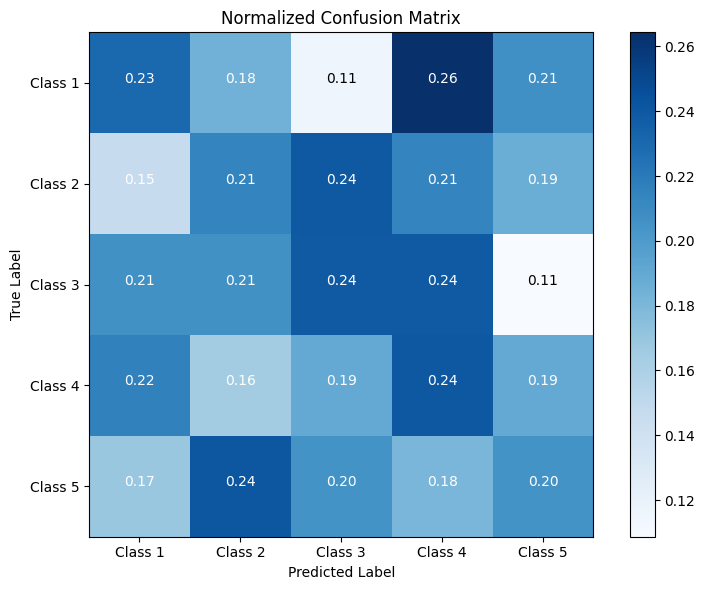

### Auto-rating of User Input and Reviews within dataset

Enter text: no
1/1 [==============================] - 5s 5s/step
Predicted class: 1

Enter text: Horrible fir, will return
1/1 [==============================] - 0s 440ms/step
Predicted class: 1

Enter text: Love it. So perfect
1/1 [==============================] - 0s 426ms/step
Predicted class: 5

Enter text: Not sure, bought 2 items, not very impressive
1/1 [==============================] - 0s 410ms/step
Predicted class: 2

Enter text: mediocre but like the color
1/1 [==============================] - 0s 428ms/step
Predicted class: 3

Enter text: As another reviewer wrote.. this is not the same jean featured on the website. same cut and style but it's a light denim wash with wiskering and worn look at the knees. i called customer service to see if this was a mistake and they said there was not really a way to check it unless i exchanged them. i didnt want the same wrong jeans again so i opted out ... too bad they are cure.
1/1 [==============================] - 0s 445ms/step
Predicted class: 2

## Approach 2A : Undersampling with 256 neurons in hidden layer, Batch size: 8, 461 training samples 

from sklearn.utils import shuffle

#Count the number of samples for each rating
rating_counts = new_datanow['Rating'].value_counts()
print(rating_counts)

Rating
5    12540
4     4908
3     2823
2     1549
1      821
Name: count, dtype: int64

#Determine the minimum count among the ratings
min_count = rating_counts.min()
print(min_count)

821

In [ ]:


# Create an empty dictionary to store maximum word count for each rating
max_word_count_by_rating = {}

# Loop over each review in the DataFrame
for rating, review_text in zip(new_datanow['Rating'], new_datanow['Concat']):
    # Tokenize the review text
    tokens =tokenizerfirst.tokenize(review_text)
    
    # Count the number of tokens (words)
    word_count = len(tokens)
    
    # Update the maximum word count for the corresponding rating
    if rating in max_word_count_by_rating:
        max_word_count_by_rating[rating] = max(max_word_count_by_rating[rating], word_count)
    else:
        max_word_count_by_rating[rating] = word_count

# Print the maximum word count for each rating
for rating, max_word_count in max_word_count_by_rating.items():
    print(f"Rating {rating}: Maximum Word Count = {max_word_count}")


In [ ]:
Rating 4: Maximum Word Count = 126
Rating 5: Maximum Word Count = 123
Rating 3: Maximum Word Count = 120
Rating 2: Maximum Word Count = 119
Rating 1: Maximum Word Count = 120

Classification Report:
              precision    recall  f1-score   support

           0       0.20      0.17      0.18        88
           1       0.26      0.21      0.23        91
           2       0.10      0.15      0.12        60
           3       0.26      0.23      0.24        92
           4       0.25      0.31      0.28        85

    accuracy                           0.22       416
   macro avg       0.22      0.21      0.21       416
weighted avg       0.22      0.22      0.22       416

## Approach 2B: Undersampling with very few -16 neurons , Batch size : 12, 307 training samples

Classification Report:
              precision    recall  f1-score   support

           0       0.17      0.20      0.18        74
           1       0.27      0.26      0.26        92
           2       0.30      0.28      0.29        89
           3       0.19      0.16      0.18        85
           4       0.19      0.20      0.19        80

    accuracy                           0.22       420
   macro avg       0.22      0.22      0.22       420
weighted avg       0.23      0.22      0.22       420

## Approach 2C: Undersampling 64 neurons , Batch size : 12, 307 training samples

Classification Report:
              precision    recall  f1-score   support

           0       0.23      0.25      0.24        85
           1       0.16      0.15      0.15        79
           2       0.22      0.22      0.22        78
           3       0.24      0.24      0.24        90
           4       0.18      0.17      0.18        88

    accuracy                           0.21       420
   macro avg       0.21      0.21      0.21       420
weighted avg       0.21      0.21      0.21       420

## Approach 3: Oversampling 64 neurons , Batch size : 12, 4702 training samples

from sklearn.utils import shuffle
from sklearn.utils import resample
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import BertTokenizer

#Shuffle the dataset
new_data_shuffled = shuffle(new_datanow, random_state=42)

#Get the count of each rating class in the dataset
rating_counts = new_data_shuffled['Rating'].value_counts()
max_count = rating_counts.max()

#Oversample the dataset to have an equal number of samples for each rating
oversampled_data = pd.concat([
    resample(new_data_shuffled[new_data_shuffled['Rating'] == rating], 
             replace=True, 
             n_samples=max_count, 
             random_state=42)
    for rating in rating_counts.index
])

#Reset the index of the oversampled dataset
oversampled_data.reset_index(drop=True, inplace=True)

#Rest of the code remains the same as before...

#Preprocess the oversampled data
Xids_oversampled = np.zeros((len(oversampled_data), seq_lennow))
Xmask_oversampled = np.zeros((len(oversampled_data), seq_lennow))

#Initializing the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

for i, phrase in enumerate(oversampled_data['Concat']):
    tokens = tokenizer.encode_plus(phrase, max_length=seq_lennow, truncation=True,
                                   padding='max_length', add_special_tokens=True,
                                   return_tensors='tf')
    Xids_oversampled[i, :] = tokens['input_ids']
    Xmask_oversampled[i, :] = tokens['attention_mask']

#Creating one-hot encoded labels
arr_oversampled = oversampled_data['Rating'].values
num_classes = len(np.unique(arr_oversampled))
labels_oversampled = np.zeros((len(oversampled_data), num_classes))
labels_oversampled[np.arange(len(oversampled_data)), arr_oversampled - 1] = 1

dataset_oversampled = tf.data.Dataset.from_tensor_slices((Xids_oversampled, Xmask_oversampled, labels_oversampled))

Epoch 1/2
  61/4702 [..............................] - ETA: 49:46:18 - loss: 0.1750 - accuracy: 0.9877

Abandoned due to long training period

## Approach 3A: Oversampling with hidden layer of 64 neurons , Batch size : 12, 1175 training samples- smaller training set

Epoch 3/4
1175/1175 [==============================] - 10231s 9s/step - loss: 0.4831 - accuracy: 0.8184 - val_loss: 0.3651 - val_accuracy: 0.8620
Epoch 4/4
1175/1175 [==============================] - 7680s 7s/step - loss: 0.3351 - accuracy: 0.8805 - val_loss: 0.1982 - val_accuracy: 0.9364

Classification Report:
              precision    recall  f1-score   support

           0       0.26      0.28      0.27       403
           1       0.19      0.18      0.19       293
           2       0.19      0.19      0.19       286
           3       0.20      0.20      0.20       307
           4       0.19      0.18      0.18       283

    accuracy                           0.21      1572
   macro avg       0.20      0.20      0.20      1572
weighted avg       0.21      0.21      0.21      1572
